# <center>Organizaci&oacute;n de Datos 75.06/95.58</center>
## <center>Trabajo Practico N°2</center>
### <center> Grupo 25</center>

In [2]:
import pandas as pd
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import xgboost as xgb
import nltk


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from unidecode import unidecode

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import StackingClassifier

from scipy.stats import uniform, randint

from nltk.stem.snowball import SpanishStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
dataset_original=pd.read_csv("https://drive.google.com/uc?export=download&id=1Vb2xrLvKI8Y-CheqUBjh9ckt1UsY76FU")
dataset_original.head()

,ID,review_es,sentimiento
0,0,"Uno de los otros críticos ha mencionado que después de ver solo 1 Oz Episodio, estará enganchado. Tienen razón, ya que esto es exactamente lo que sucedió conmigo. La primera cosa que me golpeó sobre Oz fue su brutalidad y sus escenas de violencia inconfiadas, que se encuentran a la derecha de la palabra. Confía en mí, este no es un espectáculo para los débiles de corazón o tímido. Este espectáculo no extrae punzones con respecto a las drogas, el sexo o la violencia. Es Hardcore, en el uso clásico de la palabra. Se llama OZ, ya que es el apodo dado al Penitenciario del Estado de Seguridad Máximo de Oswald. Se centra principalmente en la ciudad de Emeralda, una sección experimental de la prisión donde todas las células tienen frentes de vidrio y se enfrentan hacia adentro, por lo que la privacidad no es alta en la agenda. Em City es el hogar de muchos ... Fariarios, musulmanes, gangstas, latinos, cristianos, italianos, irlandeses y más ... así que las esposas, las miradas de muerte, las relaciones peligrosas y los acuerdos sombreados nunca están lejos. Yo diría el principal atractivo de El espectáculo se debe al hecho de que va donde otros espectáculos no se atreverían. Olvídate de las imágenes bonitas pintadas para las audiencias convencionales, olvidan el encanto, olviden el romance ... Oz no se mete. El primer episodio que he visto me sorprendió tan desagradable que fue surrealista, no podía decir que estaba listo para ello, pero cuando observé más, desarrollé un gusto por Oz, y me acostumbré a los altos niveles de violencia gráfica. No solo la violencia, sino la injusticia (Guardias torcidas que se vendrán por un níquel, los reclusos que se matarán en orden y se alejarán con él, de manera educada, los reclusos de clase media se convirtieron en perras de la prisión debido a su falta de habilidades callejeras O experiencia en la prisión) viendo oz, puede sentirse cómodo con lo que es incómodo visualización ... eso es si puedes ponerte en contacto con tu lado más oscuro.",positivo
1,1,"Una pequeña pequeña producción.La técnica de filmación es muy incuestionable, muy antigua, la moda de la BBC y le da una sensación de realismo reconfortante, y, a veces, incómodo, y, a veces, a la pieza.Los actores son extremadamente bien elegidos, Michael Sheen, no solo ""tiene todo el polari"", ¡pero tiene todas las voces por palmaditas!Realmente puede ver la edición perfecta guiada por las referencias a las entradas del diario de Williams, no solo vale la pena la observación, pero es una pieza imperrementemente escrita y realizada.Una producción magistral sobre uno de los grandes maestros de la comedia y su vida.El realismo realmente llega a casa con las pequeñas cosas: la fantasía del guardia que, en lugar de usar las técnicas de ""sueño"" tradicionales permanece sólido, entonces desaparece.Se desempeña nuestro conocimiento y nuestros sentidos, particularmente con las escenas relacionadas con Orton y Halliwell y los conjuntos (particularmente de su apartamento con murales de Halliwell que decoran cada superficie) están terriblemente bien hechos.",positivo
2,2,"Pensé que esta era una manera maravillosa de pasar tiempo en un fin de semana de verano demasiado caliente, sentado en el teatro con aire acondicionado y observando una comedia alegre.La parcela es simplista, pero el diálogo es ingenioso y los personajes son agradables (incluso el asesino en serie de la sospecha de pan del pozo).Mientras que algunos pueden decepcionarse cuando se dan cuenta de que este no es el punto de partido 2: la adicción al riesgo, pensé que era una prueba de que Woody Allen todavía está en control del estilo que muchos de nosotros hemos crecido a amar. Esto fue el más reído.En una de las comedias de Woody en años (¡Dare, digo una década?).Mientras nunca me quedé impresionado con Scarlet Johanson, en esto logró tonificar su imagen ""sexy"" y saltó a una joven promedio, pero enérgica. Esto puede que no sea la joya de la corona de su ca

In [4]:
dataset_original.shape

(50000, 3)

In [5]:
dataset_original.dtypes

ID              int64
review_es      object
sentimiento    object
dtype: object

In [6]:
dataset_original['sentimiento'].value_counts()

negativo    25000
positivo    25000
Name: sentimiento, dtype: int64

In [7]:
dataset_original.isna().sum()

ID             0
review_es      0
sentimiento    0
dtype: int64

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('snowball_data')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package snowball_data to /root/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!


True

## Preprocesamiento

Para que los modelos de predicción puedan analizar los textos de las críticas, el datset debe pasar por un preprocesamiento previo que transforme los textos en valores que puedan ser procesados por los modelos en cuestión (más precisamente vectores). Es por eso que decidimos usar el método de ***bag of words*** para este fin.
Sin embargo, en pos de hacer el algoritmo más eficiente y reducir el tamaño del conjunto de datos, y considerando que ***bag of words*** simplemente separa cada palabra que aparece en el texto, sin orden alguno, y contabiliza la cantidad de veces que aparecen, también es recomendable realizar antes una 'limpieza' del conjunto de datos, donde se filtren las stopwords, los carácteres numéricos y otros que puedan 'confundir' al algortimo.

In [9]:
stopwords_es = set(stopwords.words('spanish'))
def preprocess(text):
  text = unidecode(text.lower())
  tokens = word_tokenize(text)
  text = " ".join([word for word in tokens if word not in string.punctuation])
  tokens = word_tokenize(text)
  text = " ".join([word for word in tokens if word not in stopwords_es])
  tokens = word_tokenize(text)
  text = " ".join([word for word in tokens if len(word) > 2 and not word.isdigit()])
  return text

stemmer = SpanishStemmer()

Aplicamos el preprocesamiento y el stemmer al dataset

In [10]:
dataset = dataset_original.copy()
dataset['review_es'] = dataset['review_es'].apply(lambda x: preprocess(x))
dataset['review_es'] = dataset['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

Realizamos el ***bag of words*** del *review_es* del dataset. Utilizando CountVectorizer quedandonos unicamente con las 10000 palabras más frecuentes, las cuales a su vez se repiten por lo menos 30 veces








In [11]:
vectorizer = CountVectorizer(max_features = 10000, min_df = 30)

bag_of_words = vectorizer.fit_transform(dataset["review_es"])

vocabulary = vectorizer.get_feature_names()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
len(vocabulary)

10000

Labels será el target variable

In [13]:
labels = dataset['sentimiento'].tolist()

## Funciones

In [14]:
# Imprime los reportes y la matriz de confusión de los resultados
def plot_confusion_matrix(y_test, y_pred, title = ""):
  #Reporte de Clasificación
  print(classification_report(y_test,y_pred))

  #Creo la matriz de confusión
  table=confusion_matrix(y_test, y_pred)

  #Grafico la matriz de confusión
  sns.heatmap(table,cmap='GnBu',annot=True,fmt='g')
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

## Bayes Naive (Multinomial)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, labels, test_size=0.2, random_state=42)
naive_bayes = MultinomialNB()  
naive_bayes.fit(X_train, y_train)

MultinomialNB()

              precision    recall  f1-score   support

    negativo       0.81      0.85      0.83      4961
    positivo       0.85      0.81      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



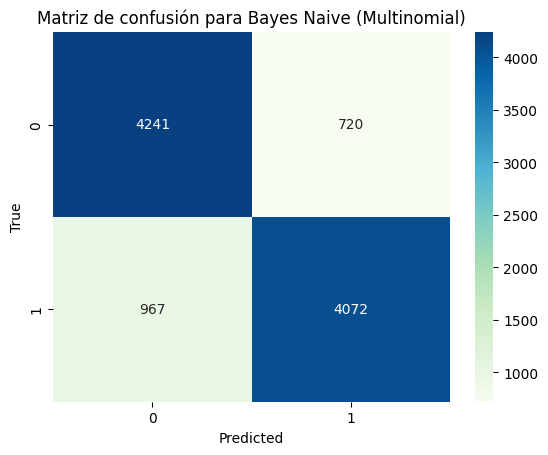

In [15]:
y_pred = naive_bayes.predict(X_test)
plot_confusion_matrix(y_test,y_pred,"Matriz de confusión para Bayes Naive (Multinomial)")

### Búsqueda de Hiperparametros

In [16]:
param_grid = {
    'alpha': [0.1, 0.05, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0]
}
naive_bayes = MultinomialNB()  
naive_bayes_gs = GridSearchCV(naive_bayes, param_grid, cv=10)
naive_bayes_gs.fit(X_train, y_train)

best_params = naive_bayes_gs.best_params_
best_estimator = naive_bayes_gs.best_estimator_
print((best_params,best_estimator))

({'alpha': 2.0}, MultinomialNB(alpha=2.0))


              precision    recall  f1-score   support

    negativo       0.81      0.85      0.83      4961
    positivo       0.85      0.81      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



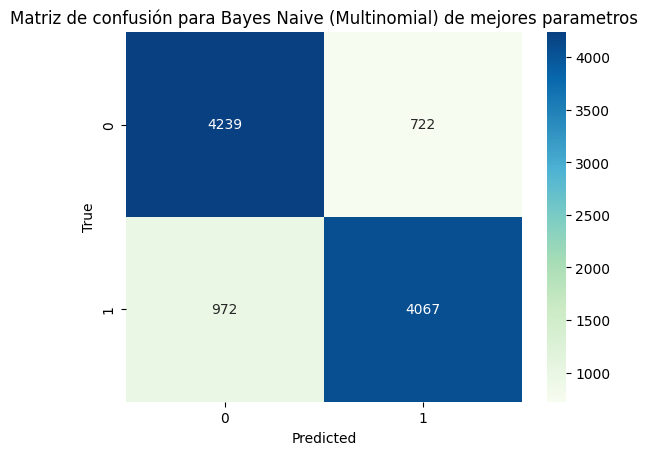

In [17]:
# Predicción en el conjunto de prueba
y_pred = best_estimator.predict(X_test)
plot_confusion_matrix(y_test,y_pred,"Matriz de confusión para Bayes Naive (Multinomial) de mejores parametros")

### Evaluar en dataset de testeo

In [18]:
dataset_test =pd.read_csv("https://drive.google.com/uc?export=download&id=1cdrY5VNTH1qjQvlJQTrdktpkwX8ETbwT")

dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: preprocess(x))
dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(dataset_test['review_es'])
predictions_test = best_estimator.predict(bag_of_words_test)
dataset_test['sentimiento'] = predictions_test
dataset_final = dataset_test[['ID','sentimiento']]
dataset_final.to_csv('bayes_naive_cv.csv', index=False)

## Bayes Naive (Bernoulli)

Dado que los features son variables que toman valores 0 y 1, podemos utilizar Bayes Naive con el modelo Bernoulli

In [19]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, labels, test_size=0.2, random_state=42)
bn_bernoulli = BernoulliNB()
bn_bernoulli.fit(X_train, y_train)

BernoulliNB()

              precision    recall  f1-score   support

    negativo       0.82      0.85      0.83      4961
    positivo       0.84      0.82      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



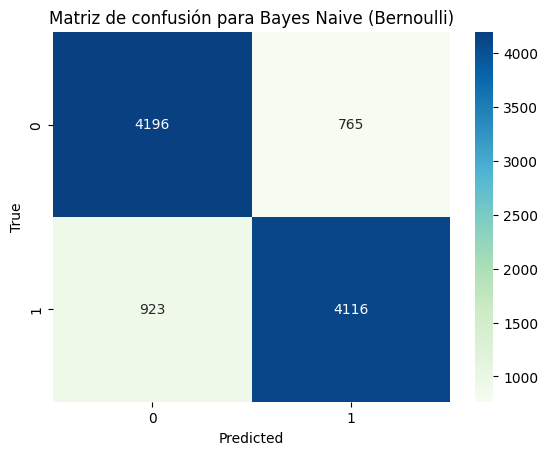

In [20]:
y_pred = bn_bernoulli.predict(X_test)
plot_confusion_matrix(y_test,y_pred,"Matriz de confusión para Bayes Naive (Bernoulli)")

### Búsqueda de Hiperparámetros

In [21]:
param_grid = {
    'alpha': [0.1, 0.05, 0.3, 0.5, 0.8, 1.0],
    'binarize': [0.0, 0.5, 1.0],
}

bn_bernoulli_model = BernoulliNB()  
bn_bernoulli_gs = GridSearchCV(bn_bernoulli_model, param_grid, cv=10)
bn_bernoulli_gs.fit(X_train, y_train)

best_params = bn_bernoulli_gs.best_params_
best_estimator = bn_bernoulli_gs.best_estimator_
print((best_params,best_estimator))

({'alpha': 0.3, 'binarize': 0.0}, BernoulliNB(alpha=0.3))


              precision    recall  f1-score   support

    negativo       0.82      0.85      0.83      4961
    positivo       0.84      0.82      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



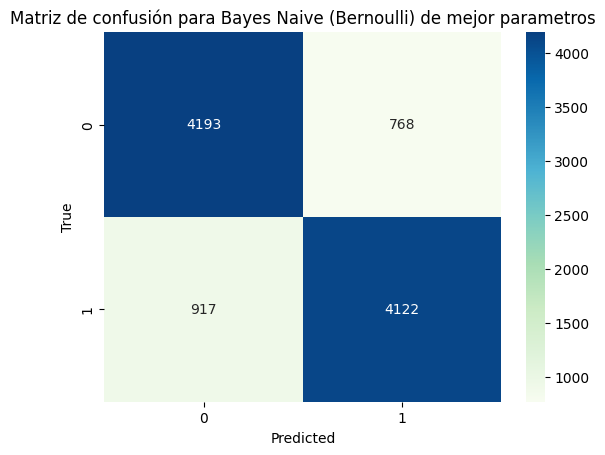

In [22]:
y_pred = best_estimator.predict(X_test)
plot_confusion_matrix(y_test,y_pred,"Matriz de confusión para Bayes Naive (Bernoulli) de mejor parametros")

### Evaluar en dataset de testeo

In [23]:
dataset_test =pd.read_csv("https://drive.google.com/uc?export=download&id=1cdrY5VNTH1qjQvlJQTrdktpkwX8ETbwT")

dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: preprocess(x))
dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(dataset_test['review_es'])
predictions_test = best_estimator.predict(bag_of_words_test)
dataset_test['sentimiento'] = predictions_test
dataset_final = dataset_test[['ID','sentimiento']]
dataset_final.to_csv('bayes_naive_bn_cv.csv', index=False)

## Random Forest

In [10]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, labels, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

    negativo       0.83      0.84      0.84      4961
    positivo       0.84      0.83      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



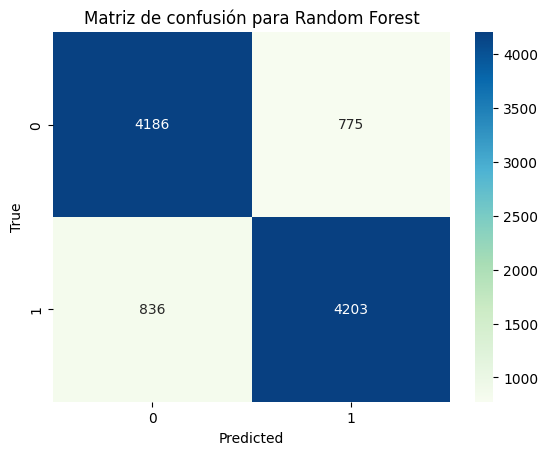

In [25]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
# Evaluación del modelo
plot_confusion_matrix(y_test,predictions,"Matriz de confusión para Random Forest")

### Búsqueda de Hiperparámetros

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
random_forest = RandomForestClassifier(random_state=42)
random_forest_gs = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)

random_forest_gs.fit(X_train, y_train)
best_params = random_forest_gs.best_params_
best_estimator = random_forest_gs.best_estimator_
print((best_params,best_estimator))

({'max_depth': None, 'n_estimators': 200}, RandomForestClassifier(n_estimators=200, random_state=42))


              precision    recall  f1-score   support

    negativo       0.84      0.85      0.84      4961
    positivo       0.85      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



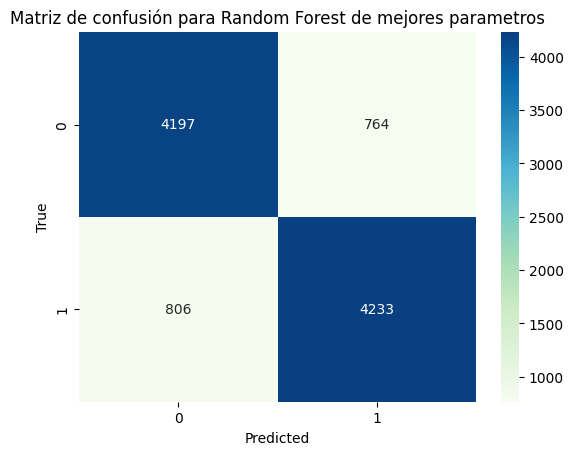

In [15]:
# Predicción en el conjuntLo de prueba
y_pred = best_estimator.predict(X_test)
plot_confusion_matrix(y_test,y_pred,"Matriz de confusión para Random Forest de mejores parametros")

### Evaluar en dataset de testeo

In [ ]:
dataset_test =pd.read_csv("https://drive.google.com/uc?export=download&id=1cdrY5VNTH1qjQvlJQTrdktpkwX8ETbwT")

dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: preprocess(x))
dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(dataset_test['review_es'])
predictions_test = random_forest.predict(bag_of_words_test)
dataset_test['sentimiento'] = predictions_test
dataset_final = dataset_test[['ID','sentimiento']]
dataset_final.to_csv('random_forest.csv', index=False)

## XGBoost

In [16]:
xgb_model = xgb.XGBClassifier(random_state
=0, n_estimators=100)


labels = dataset['sentimiento'].tolist()
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(bag_of_words, labels, test_size=0.2, random_state=42)


params = {
    'eta': 0.3,
    'max_depth': 6,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)


              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4961
           1       0.83      0.86      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



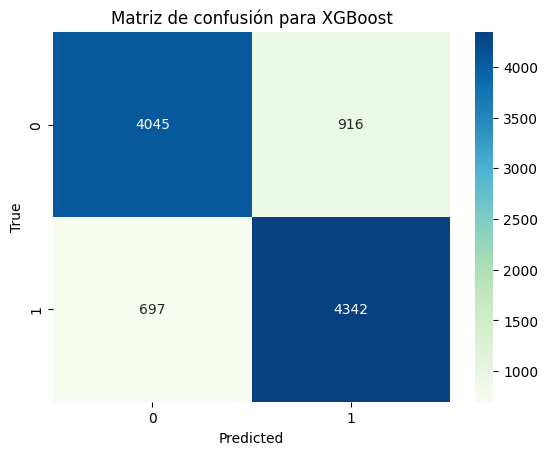

In [17]:
y_pred = xgb_model.predict(dval)

y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred]
plot_confusion_matrix(y_test,y_pred_binary,"Matriz de confusión para XGBoost")

### Búsqueda de Hiperparámetros

Para el modelo de XGBoost buscaremos por medio de un Randomized Search los hiperparámetros. 
Los parametros a obtener son
<li>gamma 
<li>learning_rate
<li>max_depth
<li>n_estimators
<li>subsample

In [18]:
xgb_model = xgb.XGBClassifier(random_state
=42, n_estimators=100)


labels = dataset['sentimiento'].tolist()
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(bag_of_words, labels, test_size=0.2, random_state=42)

params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), 
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

xgb_rs = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=5, cv=5, verbose=1, n_jobs=1, return_train_score=True)

In [19]:
xgb_rs.fit(X_train, y_train)
best_params = xgb_rs.best_params_
best_estimator = xgb_rs.best_estimator_
print(best_params, best_estimator)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'gamma': 0.18727005942368125, 'learning_rate': 0.3152142919229748, 'max_depth': 4, 'n_estimators': 107, 'subsample': 0.8394633936788146} XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.18727005942368125, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3152142919229748, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=107, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


              precision    recall  f1-score   support

           0       0.84      0.82      0.83      4961
           1       0.83      0.85      0.84      5039

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



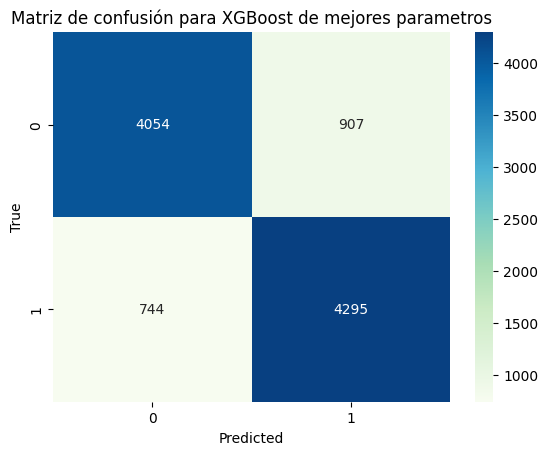

In [20]:
# Predicción en el conjunto de prueba
y_pred = best_estimator.predict(X_test)
plot_confusion_matrix(y_test,y_pred,"Matriz de confusión para XGBoost de mejores parametros")

### Evaluar en dataset de testeo

In [ ]:
dataset_test =pd.read_csv("https://drive.google.com/uc?export=download&id=1cdrY5VNTH1qjQvlJQTrdktpkwX8ETbwT")

dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: preprocess(x))
dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(dataset_test['review_es'])

dtest_xgb = xgb.DMatrix(bag_of_words_test)
predictions_test_xgb = xgb_model.predict(dtest_xgb)

predictions_test_xgb_rs = best_estimator.predict(bag_of_words_test)


In [ ]:
y_pred_binary = ["positivo" if prob >= 0.4 else "negativo" for prob in predictions_test_xgb_rs]
dataset_test['sentimiento'] = y_pred_binary
dataset_final = dataset_test[['ID','sentimiento']]
dataset_final.to_csv('xgboost_rs.csv', index=False)

## Recurrent Neuronal Nets

Elegimos **RNN** como el modelo de red neuronal con Keras y TensorFlow porque es un modelo que se suele utilizar para clasificación de documentos, tomando una secuencia de palabras en un plazo de tiempo com entrada, y como salida un único valor que declara el carácter del texto.

In [21]:
labels = dataset['sentimiento'].tolist()
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, labels, test_size=0.3, random_state=42)
print(f"tamaño de xtrain: {X_train.getnnz()} y tamaño de labels: {len(labels)}") 

tamaño de xtrain: 3162416 y tamaño de labels: 50000


In [22]:
X_train.shape

(35000, 10000)

In [23]:
label_encoder = LabelEncoder()
label_encoder.fit(["negativo", "positivo"])
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [24]:
input_dim = (X_train.shape[1],)

RNNmodel = Sequential()
input_shape = (input_dim,)
RNNmodel.add(Dense(100, activation='relu', input_shape=input_dim))
RNNmodel.add(Dropout(0.15))
RNNmodel.add(Dense(1, activation='sigmoid'))

RNNmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
RNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1000100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,000,201
Trainable params: 1,000,201
Non-trainable params: 0
_________________________________________________________________
2023-06-29 22:26:46.870589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-29 22:26:46.870633: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed c

Al ser muy grande el conjunto de datos, para poder correr el algoritmo es necesario dividir los datos en *batches* para que así el tamaño de datos que procece a la vez sea menor.

In [25]:
n_batch = 32

amount_data = X_train.shape[0]

#Se entrena por batches
for i in range(0, amount_data, n_batch):
    start = i
    end = min(i + n_batch, amount_data)
    X_portion = X_train[start:end].toarray()
    y_portion = y_train_encoded[start:end]
    RNNmodel.fit(X_portion, y_portion)

1/1 [==============================] - 0s 262ms/step - loss: 0.1897 - accuracy: 0.9167


In [26]:
X_test_dense = X_test.toarray()

469/469 [==============================] - 3s 6ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7411
           1       0.89      0.87      0.88      7589

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



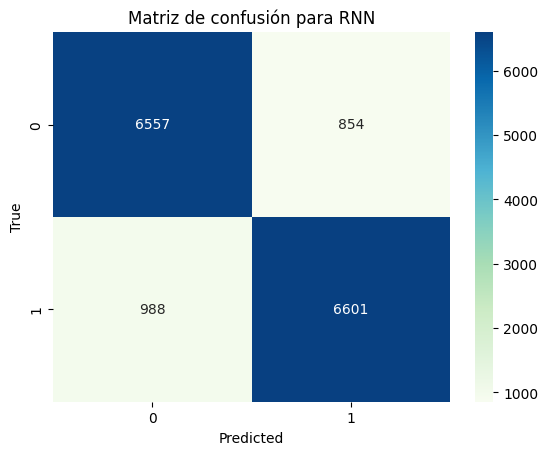

In [27]:
predictions = RNNmodel.predict(X_test_dense)
y_predic_cat = np.where(predictions > 0.5,1,0)
# Evaluación del modelo
plot_confusion_matrix(y_test_encoded,y_predic_cat,"Matriz de confusión para RNN")

In [28]:
dataset_test =pd.read_csv("https://drive.google.com/uc?export=download&id=1cdrY5VNTH1qjQvlJQTrdktpkwX8ETbwT")

dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: preprocess(x))
dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

In [29]:
bag_of_words_test = vectorizer.transform(dataset_test['review_es'])

predictions_test = RNNmodel.predict(bag_of_words_test)

269/269 [==============================] - 1s 3ms/step


In [30]:
y_pred_binary = ["positivo" if prob >= 0.5 else "negativo" for prob in predictions_test]
dataset_test['sentimiento'] = y_pred_binary
dataset_final = dataset_test[['ID','sentimiento']]
dataset_final.to_csv('rnn2.csv', index=False)

## Ensambles

In [15]:
labels = dataset['sentimiento'].tolist()
labels =  [1 if label == "positivo" else 0 for label in labels]
x_train_stacking, x_test_stacking, y_train, y_test = train_test_split(bag_of_words,
                                                    labels, 
                                                    test_size=0.3,
                                                    random_state=2)

In [16]:
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
    scores = cross_val_score(model,bag_of_words , labels, scoring='f1', cv=cv, verbose=1, n_jobs=-1, error_score='raise')
    return scores

In [17]:
#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=30)),
               ('svm', SVC()),
               ('XGBoost',xgb.XGBClassifier(random_state =0, n_estimators=50) )]
#Meta Modelo
meta_model = LogisticRegression()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=2,
                                    verbose=2)
stacking_scores = evaluate_model(stacking_model, x_train_stacking, y_train)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.6s finished
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

In [19]:
stacking_model.fit(x_train_stacking,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s finished
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

StackingClassifier(cv=2,
                   estimators=[('random_forest',
                                RandomForestClassifier(n_estimators=30)),
                               ('svm', SVC()),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=50, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=0, ...))],
                   final_estimator=LogisticRegression(), passthrough=True,
                   verbose=2)

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      7499
           1       0.86      0.86      0.86      7501

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



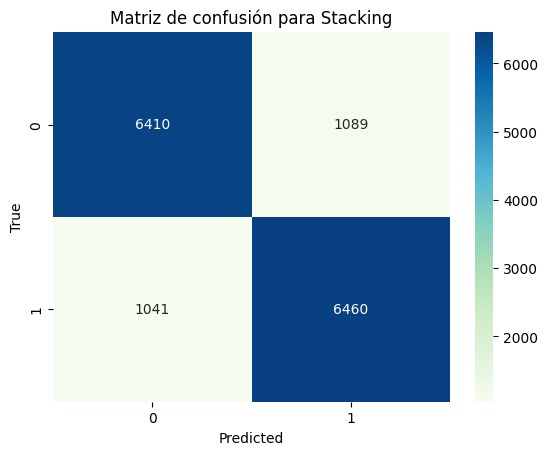

In [21]:
y_pred = stacking_model.predict(x_test_stacking)
plot_confusion_matrix(y_test,y_pred,"Matriz de confusión para Stacking")

In [ ]:
dataset_test =pd.read_csv("https://drive.google.com/uc?export=download&id=1cdrY5VNTH1qjQvlJQTrdktpkwX8ETbwT")

dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: preprocess(x))
dataset_test['review_es'] = dataset_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(dataset_test['review_es'])

predictions_test = stacking_model.predict(bag_of_words_test)
pred_test = ["positivo" if pred else "negativo" for pred in predictions_test]
dataset_test['sentimiento'] = pred_test
dataset_final = dataset_test[['ID','sentimiento']]
dataset_final.to_csv('ensamble.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=268aaca1-346d-4ab0-ac9d-7a98095e8f98' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>